# ***Prepare step***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm


# ***1.Phân loại cảm xúc***

In [ ]:
emodb_path = "/content/drive/MyDrive/wav"

# Mapping ký tự mã cảm xúc → nhãn đầy đủ
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# Danh sách lưu dữ liệu
data = []

# Duyệt qua tất cả các file .wav trong thư mục
for filename in os.listdir(emodb_path):
    if filename.endswith('.wav'):
        emotion_code = filename[5]
        emotion = emotion_map.get(emotion_code)

        if emotion:
            data.append({
                'filename': filename,
                'emotion': emotion
            })

# Tạo DataFrame
df = pd.DataFrame(data)

# Xuất ra file CSV
df.to_csv("emodb_labels.csv", index=False)



# ***2.Visualize số lượng mẫu và cân bằng số lượng cảm xúc***

      filename    emotion
0  11b02Fd.wav  happiness
1  11a01Ab.wav       fear
2  08a05Fe.wav  happiness
3  03a02Nc.wav    neutral
4  03b03Wc.wav      anger


<ipython-input-4-7cde2b836469>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')


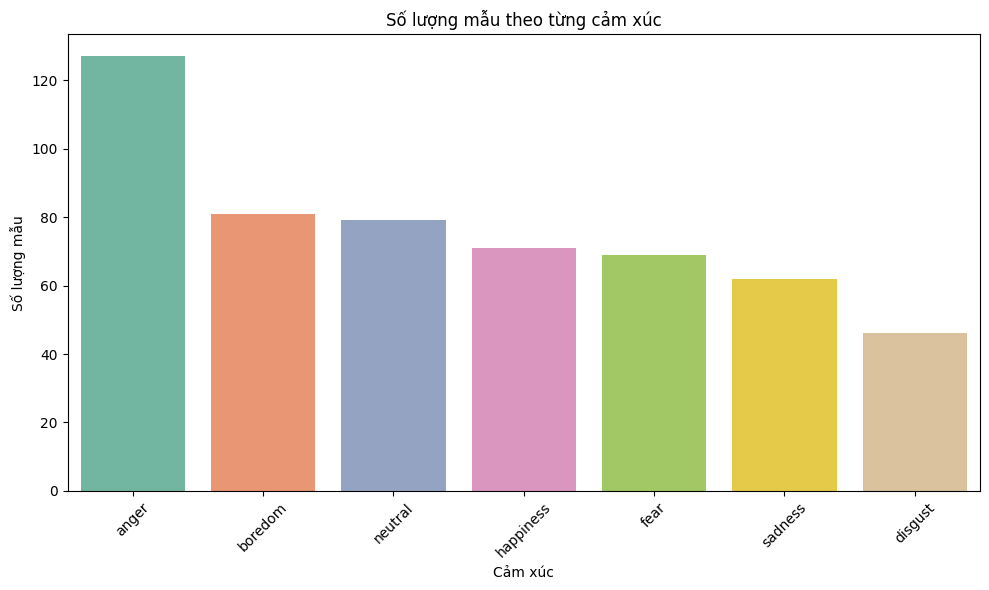

In [ ]:
df = pd.read_csv("/content/emodb_labels.csv")
print(df.head())

# Đếm số lượng mẫu theo từng nhãn cảm xúc
emotion_counts = df['emotion'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')
plt.title("Số lượng mẫu theo từng cảm xúc")
plt.xlabel("Cảm xúc")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ***3.Phân tích thời lượng audio***

In [ ]:
df = pd.read_csv("/content/emodb_labels.csv")
audio_folder = "/content/drive/MyDrive/wav"

# Thêm cột duration
durations = []
for fname in tqdm(df['filename']):
    file_path = os.path.join(audio_folder, fname)
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        durations.append(None)
        print(f"Lỗi với file {fname}: {e}")

df['duration'] = durations
df = df.dropna(subset=['duration'])


100%|██████████| 535/535 [00:30<00:00, 17.30it/s] 


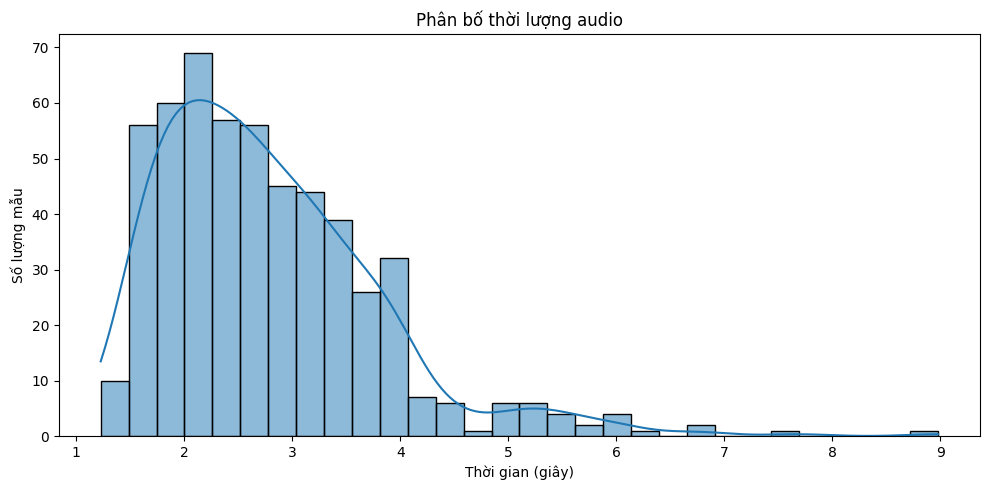

<ipython-input-6-2f5d2ae644b4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='duration', palette='Set2')


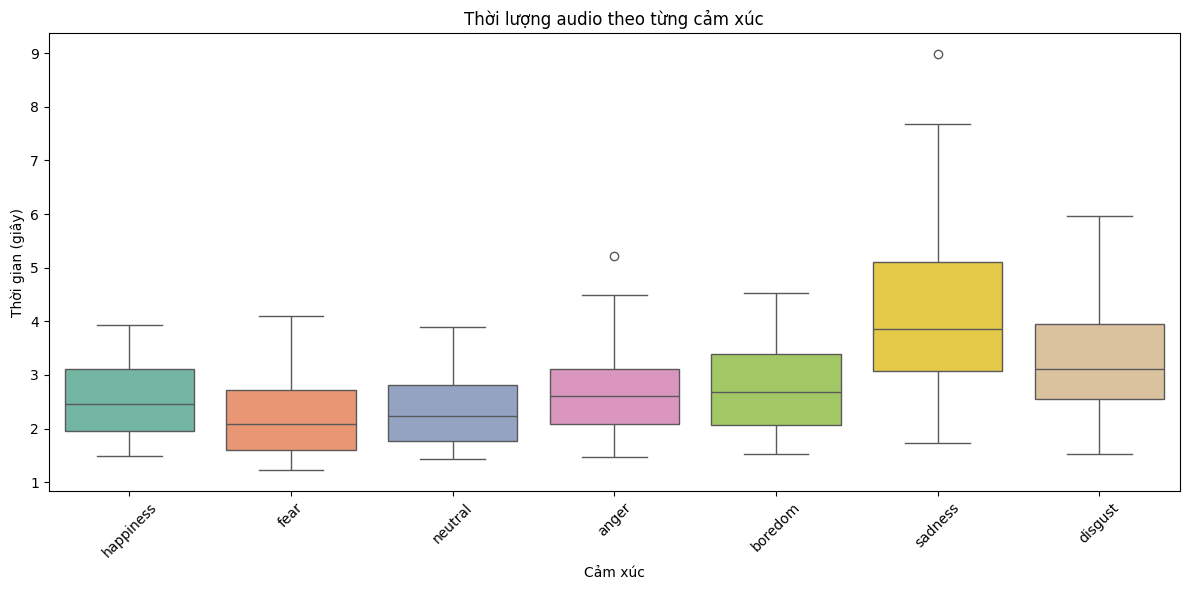

In [ ]:
# Histogram toàn tập
plt.figure(figsize=(10, 5))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title("Phân bố thời lượng audio")
plt.xlabel("Thời gian (giây)")
plt.ylabel("Số lượng mẫu")
plt.tight_layout()
plt.show()

# Boxplot theo cảm xúc
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='emotion', y='duration', palette='Set2')
plt.title("Thời lượng audio theo từng cảm xúc")
plt.xlabel("Cảm xúc")
plt.ylabel("Thời gian (giây)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ***3.Visualize Waveform theo từng Emotion***

In [ ]:
# Tạo dict chứa 1 sample cho mỗi cảm xúc
emotion_samples = {}

for emotion in df['emotion'].unique():
    sample_row = df[df['emotion'] == emotion].iloc[0]
    emotion_samples[emotion] = sample_row['filename']


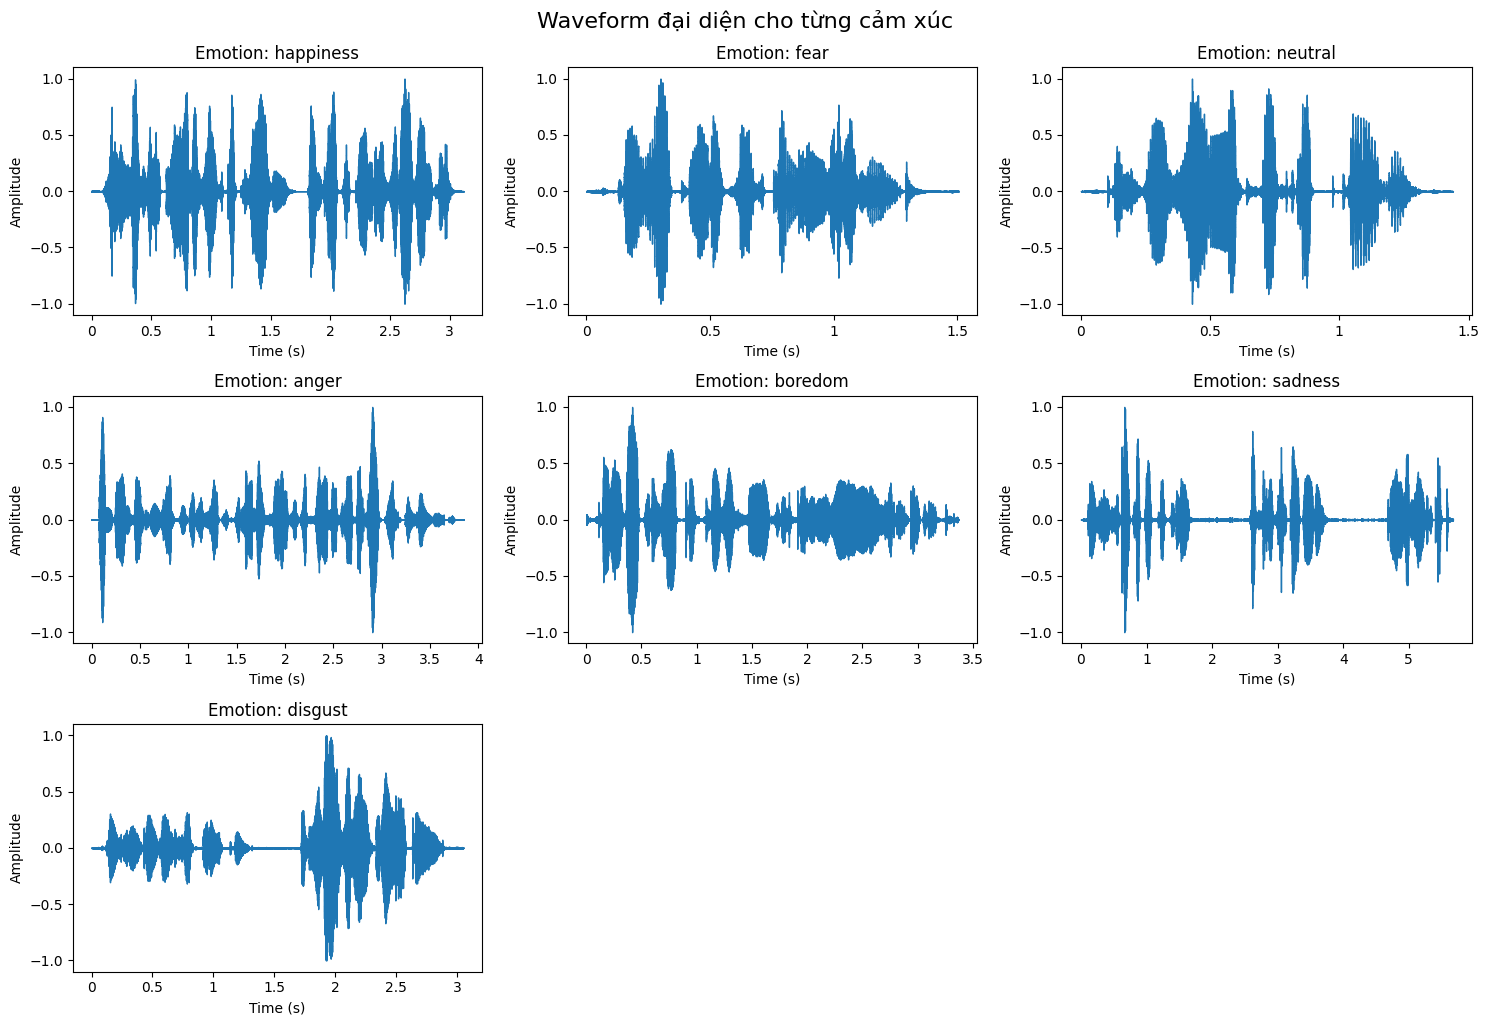

In [ ]:
audio_folder = "/content/drive/MyDrive/wav"
plt.figure(figsize=(15, 10))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(audio_folder, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Waveform đại diện cho từng cảm xúc", fontsize=16, y=1.02)
plt.show()


# ***3.1 Chọn ra độ dài phù hợp nhất cho toàn bộ dataset***


In [ ]:
import numpy as np
# Phân tích để chọn ra độ dài phù hợp (ví dụ dùng percentile)
durations = df["duration"].values
target_duration = np.percentile(durations, 75)
sample_rate = 16000
target_length = int(target_duration * sample_rate)
print(f"Độ dài chuẩn hóa được chọn: {target_duration:.2f} giây ({target_length} samples)")


Độ dài chuẩn hóa được chọn: 3.31 giây (52934 samples)


# ***3.2 Padding với audio ngắn***


In [ ]:
def pad_audio(audio, target_length):
    if len(audio) < target_length:
        pad_width = target_length - len(audio)
        return np.pad(audio, (0, pad_width), mode='constant')
    return audio


# ***3.3 Slicing với audio dài***


In [ ]:
def slice_audio(audio, target_length):
    if len(audio) > target_length:
        return audio[:target_length]
    return audio


# ***3.4 Áp dụng padding/slicing cho toàn bộ audio***


In [ ]:
print(df.columns)


Index(['filename', 'emotion', 'duration'], dtype='object')


In [ ]:
emodb_path = "/content/drive/MyDrive/wav"  # thư mục chứa các file .wav
normalized_audios = []

for fname in df["filename"]:
    full_path = os.path.join(emodb_path, fname)
    audio, _ = librosa.load(full_path, sr=sample_rate)
    audio = pad_audio(audio, target_length)
    audio = slice_audio(audio, target_length)
    normalized_audios.append(audio)


# ***4.Trích xuất đặc trưng MFCC,EDA only***


In [ ]:
feature_rows = []

for i, audio in enumerate(normalized_audios):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio)

    row = {
        'emotion': df.loc[i, 'emotion'],
        **{f'mfcc_{j+1}': mfcc[j].mean() for j in range(13)},
        'chroma_mean': chroma.mean(),
        'mel_mean': mel.mean(),
        'centroid_mean': centroid.mean(),
        'zcr_mean': zcr.mean()
    }
    feature_rows.append(row)

df_features = pd.DataFrame(feature_rows)


<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


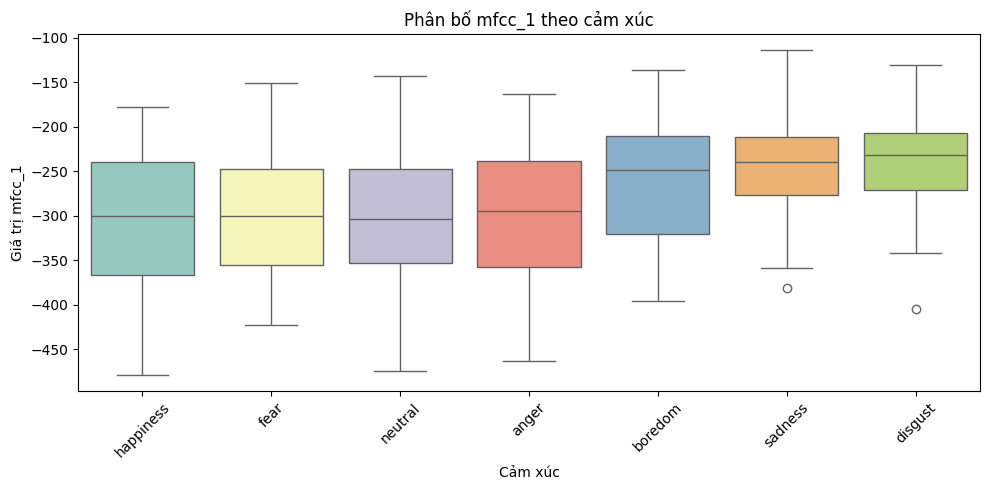

<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


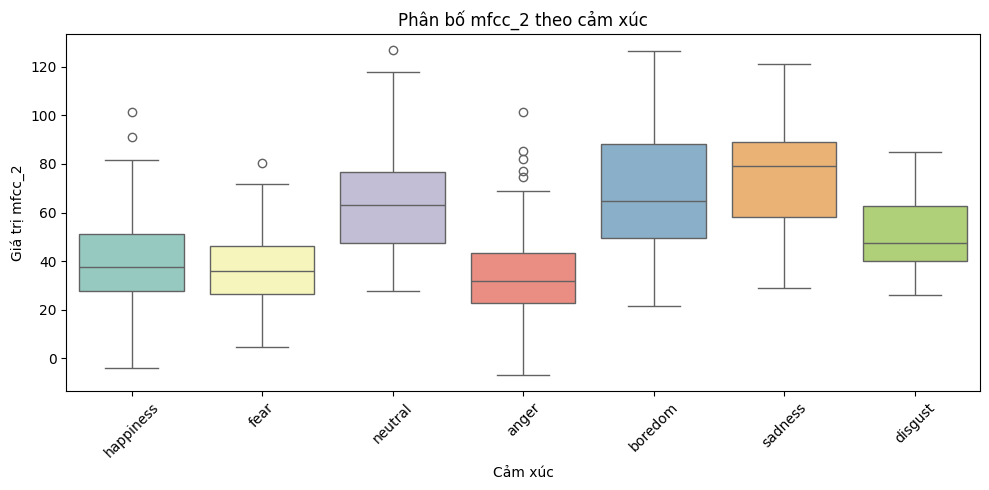

<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


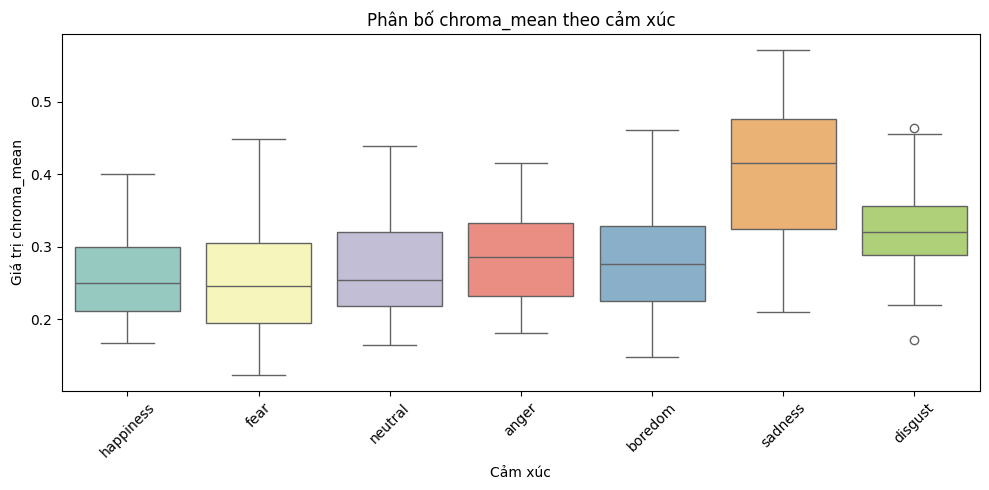

<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


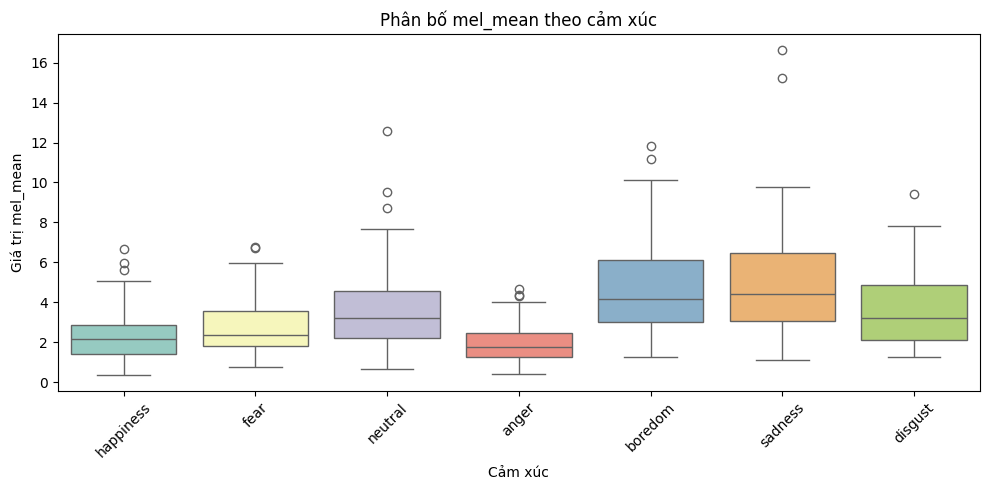

<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


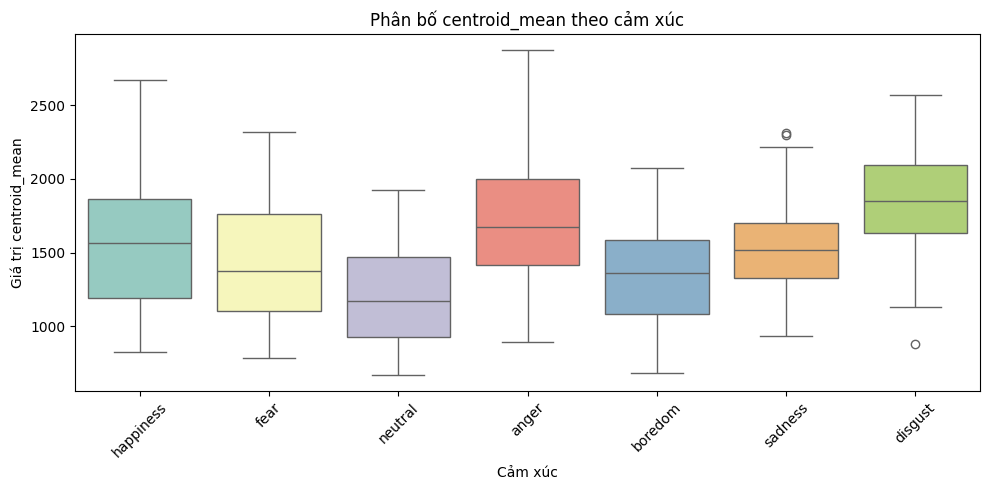

<ipython-input-15-7cdff00618bf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')


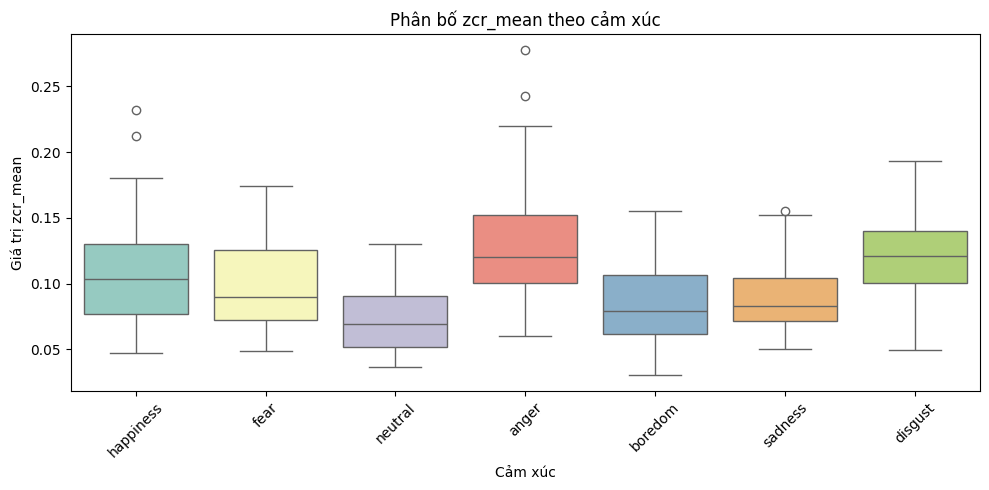

In [ ]:


# Boxplot các đặc trưng theo cảm xúc
for feature in ['mfcc_1', 'mfcc_2', 'chroma_mean', 'mel_mean', 'centroid_mean', 'zcr_mean']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_features, x='emotion', y=feature, palette='Set3')
    plt.title(f"Phân bố {feature} theo cảm xúc")
    plt.xlabel("Cảm xúc")
    plt.ylabel(f"Giá trị {feature}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

# Tạo lại mfcc_features từ normalized_audios
mfcc_features = []
labels = []

for audio, label in zip(normalized_audios, df['emotion']):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfcc_features.append(mfcc)
    labels.append(label)

# Chuyển sang numpy array
X_3d = np.stack(mfcc_features, axis=0)  # (samples, 13, time_steps)
y = np.array(labels)

# Lưu ra file
np.save("X_mfcc3d.npy", X_3d)
np.save("y_labels.npy", y)


# ***5.Visualize đặc trưng MFCC theo cảm xúc***


# ***Hiển thị MFCC 2D của 1 mẫu âm thanh***

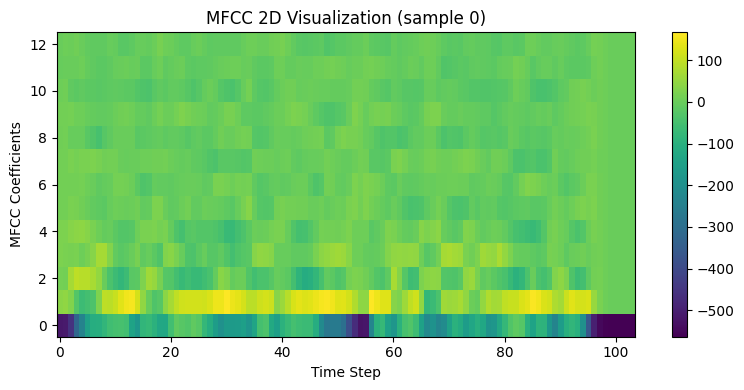

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(X_3d[0], aspect='auto', origin='lower')
plt.title("MFCC 2D Visualization (sample 0)")
plt.xlabel("Time Step")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.tight_layout()
plt.show()
